In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, random, copy, pickle
from tqdm import tqdm
import time

In [3]:
class SudokuGame:
    def __init__(self, board=None):
        if board is None:
            board = np.full((9, 9), "_")
        self.board = board
        self.candidates = dict()
        self.editableCells = set()
        self.assignments = 0  # useful for comparing backtracking and CP performance

        # initialize candidates dictionary and editable cells
        for i in range(9):
            for j in range(9):
                cell = (i,j)  # tupled position
                value = self.board[i][j]  # value at that slot

                if value == '_':  # if this is an empty value
                    self.candidates[cell] = self.getCandidates(cell)
                    self.editableCells.add(cell)
                else:
                    self.candidates[cell] = [value]

    def getCandidates(self, cell):
        possible = list(range(1,10))
        i, j = cell
        for k in range(9):
            # eliminate row dupes:
            if self.getValue((i, k)) in possible:
                possible.remove(self.getValue((i, k)))

            # eliminate col dupes:
            if self.getValue((k, j)) in possible:
                possible.remove(self.getValue((k, j)))

            # eliminate subgrid dupes:
            r, c = self.getWhichSubgrid(cell)
            for row in range(r, r+3):
                for col in range(c, c+3):
                    if self.getValue((row, col)) in possible:
                        possible.remove(self.getValue((row, col)))
        return possible


    def getValue(self, cell):
        i, j = cell
        return self.board[i][j]
    
    def printBoard(self):
        for i in self.board:
            for j in i[:-1]:
                print(f" {j} ", end='')
            print(f" {i[-1]}")

    def checkBoard(self):
        # check for non-digits
        if not set(self.board.flatten()).issubset(set([1,2,3,4,5,6,7,8,9,"_"])):
            return False

        # check each row
        for row in self.board:
            for digit in range(1, 10):
                if list(row).count(digit) > 1:
                    return False

        # check each column
        for i in range(9):
            column = [row[i] for row in self.board]
            for digit in range(1, 10):
                if column.count(digit) > 1:
                    return False

        # check each subgrid
        subgrids = [self.board[:3, :3], self.board[:3, 3:6], self.board[:3, 6:], 
                    self.board[3:6, :3], self.board[3:6, 3:6], self.board[3:6, 6:], 
                    self.board[6:, :3], self.board[6:, 3:6], self.board[6:, 6:]]

        for subgrid in subgrids:
            flattened_subgrid = subgrid.flatten()
            for digit in range(1, 10):
                if list(flattened_subgrid).count(digit) > 1:
                    return False

        return True
    
    def getWhichSubgrid(self, cell):
        i, j = cell
        return ((i // 3)*3 , (j // 3)*3)
    
    def conflicts(self, cell, value):
        row, col = cell
        numConflicts = 0

        # check for row and column conflicts
        for i in range(9):
            # check for a row conflict
            if self.board[row][i] == value and i != col:
                numConflicts += 1

            # check for a column conflict
            if self.board[i][col] == value and i != row:
                numConflicts += 1

        # check for subgrid conflicts
        row_start = (row // 3) * 3
        col_start = (col // 3) * 3

        for i in range(row_start, row_start + 3):
            for j in range(col_start, col_start + 3):
                if self.board[i][j] == value and not (i == row and j == col):
                    numConflicts += 1

        return numConflicts
    
    def totalConflicts(self):
        total = 0
        for i in range(9):
            for j in range(9):
                value = self.board[i][j]
                total += self.conflicts((i, j), value)
                
        return total

    def isComplete(self):
        for i in range(9):
            for j in range(9):
                if self.board[i][j] == '_':
                    return False
        return True

## util - for board generation

def redactCells(board, k):
    newBoard = board.copy().astype(object)
    cellsToBlock = set()
    while len(cellsToBlock) < k:
        cellsToBlock.add((random.randint(0,8), random.randint(0,8)))

    for cell in cellsToBlock:
        i, j = cell
        newBoard[i][j] = '_'

    return newBoard

## solver algorithms

# minConflicts
def minConflicts(game, maxSteps=1000, plateauThreshold=10, printOutput=True):
    # current = an initial complete assignment
    for cell in game.editableCells:
        i, j = cell
        game.board[i][j] = random.randint(1,9)

    plateauTracker = 0

    conflictsLog = []

    # for step in tqdm(range(maxSteps), desc="minConflicts"):
    for step in range(maxSteps):
        if plateauTracker > plateauThreshold:
            for cell in game.editableCells:
                i, j = cell
                game.board[i][j] = random.randint(1,9)

        conflictsLog.append(game.totalConflicts())

        if game.totalConflicts() == 0:
            if printOutput:
                print(f"Solved the board in {step} steps.")
                game.printBoard()
            return conflictsLog

        conflictingCells = []
        for cell in game.editableCells:
            numConflicts = game.conflicts(cell, game.getValue(cell))
            if numConflicts > 0:
                conflictingCells.append(cell)

        var = random.choice(conflictingCells)
        i, j = var
        conflictsFromValues = {}
        currentConflicts = game.totalConflicts()

        for value in range(1,10):
            game.board[i][j] = value
            conflictsFromValues[value] = game.totalConflicts()

        game.board[i][j] = "_"
        leastConflicts = min(conflictsFromValues.values())
        bestValues = [value for value in conflictsFromValues if conflictsFromValues[value] == leastConflicts]
        bestValue = random.choice(bestValues)
        game.board[i][j] = bestValue

        if game.totalConflicts() >= currentConflicts:
            plateauTracker += 1
        else:
            plateauTracker = 0

    if printOutput:
        print("Max steps reached.")
    return conflictsLog

# backtracking
def backtrackingSearch(game, randomOrder=False, printOutput=True):
    start = time.time()
    result = backtrack(game, 0, randomOrder, printOutput)
    end = time.time()
    return result, end-start


def backtrack(game, step, randomOrder, printOutput):
    # goal test
    if game.totalConflicts() == 0 and game.isComplete():
        if printOutput:
            print(f"Solution found in {step} steps!")
        return game.board
    
    var = selectEmptyCell(game, randomOrder)
    if var is None:
        if game.totalConflicts() > 0:
            if printOutput:
                print("No possible solution")
        return None
    
    i, j = var
    for value in range(1,10):  # iterate across domain
        if game.conflicts(var, value) == 0:  # if there are no conflicts
            game.board[i][j] = value
            game.assignments += 1
            result = backtrack(game, step + 1, randomOrder, printOutput)
            if result is not None:  # if the assignment was successful
                return result
            # otherwise, failure
            game.board[i][j] = '_'

    if step == 0:  # if no solution was found:
        if printOutput:
            print("No solution found")
    return None

def selectEmptyCell(game, randomOrder=False):
    emptyCells = []
    for i in range(9):
        for j in range(9):
            if game.board[i][j] == '_':  # if cell is empty
                emptyCells.append((i, j))
    if len(emptyCells) == 0:
        return None
    if randomOrder:
        random.shuffle(emptyCells)
    return emptyCells[0]

def constraintProp(game, step=0, printOutput=True):
    start = time.time()

    if printOutput:
            print(f"Step {step}")
    # goal test
    if game.isComplete() and game.totalConflicts() == 0:
        end = time.time()
        print(f"Solution found in {step} steps.")
        return game.board, end - start
    
    # use Minimum Remaining Values heuristic to select an empty cell
    if printOutput:
            print("Selecting MRV cell")
    var = selectMRVCell(game)
    if printOutput:
            print(f"Selected cell: {var}")
    if var is None:
        end = time.time()
        return None, end - start
    
    i, j = var
    originalCandidates = game.candidates[var].copy()

    for value in originalCandidates:
        if printOutput:
            print(f"Assigning value {value} to cell {var}")
        game.board[i][j] = value  # assign the value
        game.candidates[var] = [value]  # update that cell's candidates to itself

        if updateCandidates(game) and constraintProp(game, step+1, printOutput)[0] is not None:
            end = time.time()
            return game.board, end - start
        
        # otherwise, the assignment led to failure
        game.board[i][j] = '_'
        game.candidates[var] = originalCandidates

    end = time.time()
    return None, end - start

def selectMRVCell(game):
    min_candidates = 10
    selected_cell = None
    for cell in game.editableCells:
        num_candidates = len(game.candidates[cell])
        if num_candidates < min_candidates and game.getValue(cell) == '_':
            min_candidates = num_candidates
            selected_cell = cell
    return selected_cell

def updateCandidates(game):
    for cell in [x for x in game.editableCells if game.getValue(x) == '_']:
        game.candidates[cell] = game.getCandidates(cell)
        
        if len(game.candidates[cell]) == 0:
            return False
    return True

sol1 = np.array([   [5,3,4,6,7,8,9,1,2],
                    [6,7,2,1,9,5,3,4,8],
                    [1,9,8,3,4,2,5,6,7],
                    [8,5,9,7,6,1,4,2,3],
                    [4,2,6,8,5,3,7,9,1],
                    [7,1,3,9,2,4,8,5,6],
                    [9,6,1,5,3,7,2,8,4],
                    [2,8,7,4,1,9,6,3,5],
                    [3,4,5,2,8,6,1,7,9]])

board1 = np.array([ [5,3,"_","_",7,"_","_","_","_"],
                    [6,"_","_",1,9,5,"_","_","_"],
                    ["_",9,8,"_","_","_","_",6,"_"],
                    [8,"_","_","_",6,"_","_","_",3],
                    [4,"_","_",8,"_",3,"_","_",1],
                    [7,"_","_","_",2,"_","_","_",6],
                    ["_",6,"_","_","_","_",2,8,"_"],
                    ["_","_","_",4,1,9,"_","_",5],
                    ["_","_","_","_",8,"_","_",7,9]])

sol2 = np.array([   [7,8,2,9,1,3,4,5,6],
                    [1,4,5,8,7,6,9,2,3],
                    [6,9,3,4,5,2,7,1,8],
                    [2,7,9,5,3,1,8,6,4],
                    [5,6,4,2,9,8,1,3,7],
                    [3,1,8,7,6,4,5,9,2],
                    [4,5,1,6,2,7,3,8,9],
                    [9,2,7,3,8,5,6,4,1],
                    [8,3,6,1,4,9,2,7,5]])

impossible = np.array([ [7,8,"_",9,1,2,4,5,6],
                    [1,4,5,8,7,6,9,2,3],
                    [6,9,3,4,5,2,7,1,8],
                    [2,7,"_",5,3,1,"_",6,4],
                    [5,6,4,2,9,8,1,3,7],
                    [3,1,8,7,6,4,5,9,2],
                    [4,5,1,"_",2,7,3,8,9],
                    [9,2,7,3,8,5,6,"_",1],
                    [8,3,6,1,4,9,2,7,5]])


In [1000]:
redactCells(sol1, 20)

array([['_', 3, 4, 6, 7, 8, '_', 1, 2],
       [6, 7, '_', 1, '_', 5, 3, 4, 8],
       [1, '_', 8, '_', '_', '_', 5, 6, 7],
       ['_', 5, 9, 7, 6, 1, 4, 2, '_'],
       [4, 2, 6, 8, 5, 3, 7, 9, '_'],
       ['_', '_', 3, 9, 2, 4, 8, 5, 6],
       [9, 6, '_', 5, 3, 7, 2, 8, 4],
       ['_', 8, 7, '_', 1, 9, '_', 3, 5],
       ['_', 4, 5, '_', '_', 6, 1, 7, 9]], dtype=object)

In [4]:
## Code used to generate solvable test boards
# 
# testBoards = {i: list() for i in range(1,57)}
# 
# for i in range(1,57):
#     while len(testBoards[i]) < 10:
#         game = SudokuGame(redactCells(sol1, i))
#         board = copy.deepcopy(game.board)
#         solution = backtrackingSearch(game)
#         if solution is not None:
#             testBoards[i].append(board)
# 
# with open('testBoards.pickle', 'wb') as file:
#     pickle.dump(testBoards, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('testBoards.pickle', 'rb') as file:
    boards = pickle.load(file)

boards[20][1]

array([[5, '_', 4, '_', 7, 8, '_', '_', 2],
       ['_', '_', 2, '_', 9, '_', 3, 4, 8],
       [1, 9, 8, '_', 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, '_', '_', 2, 3],
       [4, 2, 6, '_', 5, '_', 7, '_', 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, '_', 7, 2, '_', 4],
       ['_', 8, 7, 4, 1, 9, 6, 3, 5],
       [3, '_', '_', '_', 8, 6, 1, 7, 9]], dtype=object)

In [9]:
game = SudokuGame(boards[20][1].copy())
game.board
backtrackingSearch(game)

Solution found in 20 steps!


(array([[5, 3, 4, 6, 7, 8, 9, 1, 2],
        [6, 7, 2, 1, 9, 5, 3, 4, 8],
        [1, 9, 8, 3, 4, 2, 5, 6, 7],
        [8, 5, 9, 7, 6, 1, 4, 2, 3],
        [4, 2, 6, 8, 5, 3, 7, 9, 1],
        [7, 1, 3, 9, 2, 4, 8, 5, 6],
        [9, 6, 1, 5, 3, 7, 2, 8, 4],
        [2, 8, 7, 4, 1, 9, 6, 3, 5],
        [3, 4, 5, 2, 8, 6, 1, 7, 9]], dtype=object),
 0.007710933685302734)

In [826]:
# How to test the results of minConflicts?
# 
# minConflictRuns = pd.DataFrame(columns=['boardSize', 'conflicts'], index=np.arange(300))
# run = 0
# for size in tqdm(boards, desc="Sizes"):
#     for i in tqdm(range(10), desc=f"Iterating over size {size}"):
#         game = SudokuGame(boards[size][i].copy())
#         minConflictRuns.boardSize[run] = size
#         minConflictRuns.conflicts[run] = minConflicts(game, maxSteps=5000, plateauThreshold=20, printOutput=False)
#         run += 1

# for i in minConflictRuns.index:
#     if minConflictRuns.loc[i, 'conflicts'][-1] == 0:
#         minConflictRuns.loc[i, 'success'] = True  # create a success column
#     minConflictRuns.loc[i, 'steps'] = len(minConflictRuns.loc[i, 'conflicts'])  # get the number of steps

# minConflictRuns.to_csv('minConflictRuns.csv')

Text(0, 0.5, 'Average steps taken')

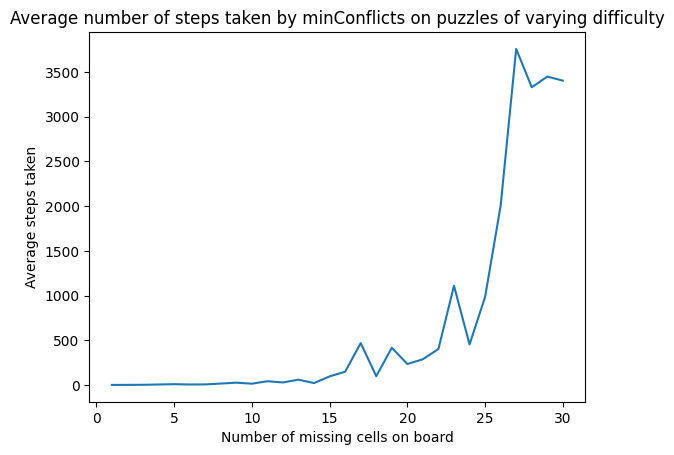

In [747]:
plt.plot(minConflictRuns.groupby('boardSize')['steps'].mean())
plt.title('Average number of steps taken by minConflicts on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Average steps taken')

Text(0, 0.5, 'Total conflicts')

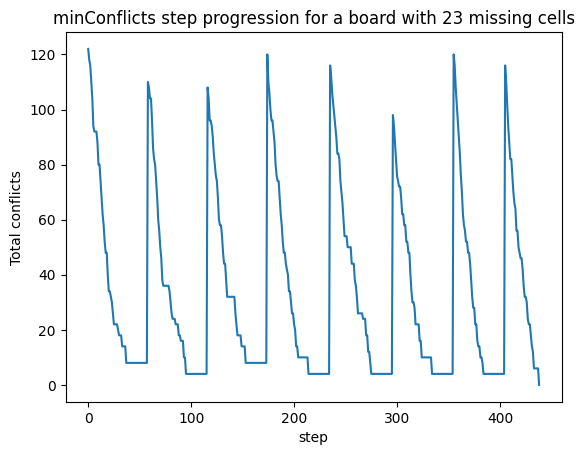

In [811]:
boardSize = 23
subBoard = random.randint(0,9)
index = boardSize*10 + subBoard
plt.plot(minConflictRuns.loc[index, 'conflicts'])
plt.title(f"minConflicts step progression for a board with {boardSize} missing cells")
plt.xlabel('step')
plt.ylabel('Total conflicts')

In [920]:
# How to test the results of backtracking?
# 
# backtrackingRuns = pd.DataFrame(columns=['boardSize', 'solveTime'], index=np.arange(570))
# 
# run = 0
# for size in tqdm(boards, desc="Sizes"):
#     for i in tqdm(range(10), desc=f"Iterating over size {size}"):
#         game = SudokuGame(boards[size][i].copy())
#         backtrackingRuns.boardSize[run] = size
#         backtrackingRuns.solveTime[run] = backtrackingSearch(game, printOutput=False)[1]
#         run += 1

Text(0, 0.5, 'Solve time (seconds)')

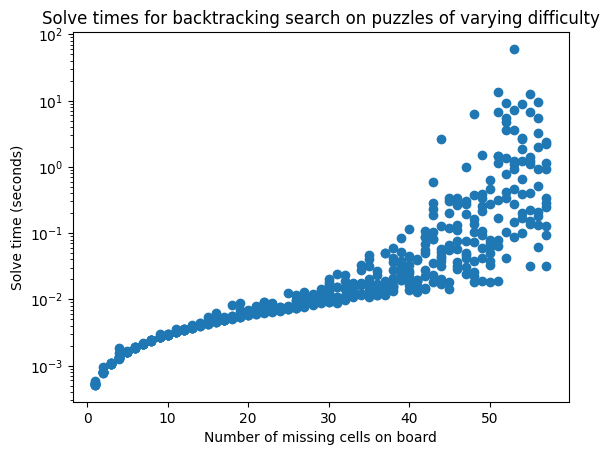

In [919]:
plt.scatter(backtrackingRuns.boardSize, backtrackingRuns.solveTime)
plt.yscale('log')
plt.title('Solve times for backtracking search on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Solve time (seconds)')

Text(0, 0.5, 'Solve time (seconds)')

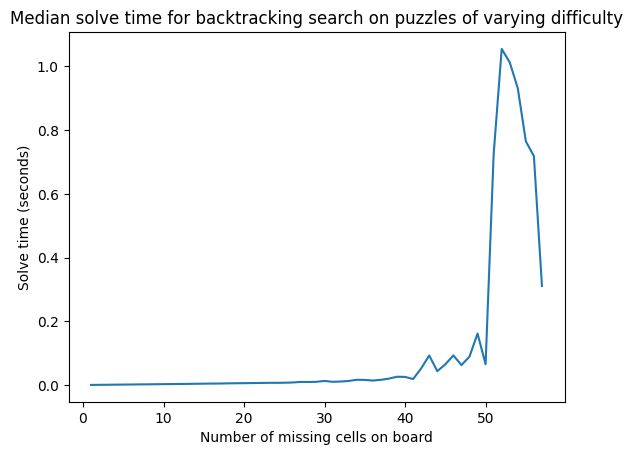

In [918]:
plt.plot(backtrackingRuns.groupby('boardSize')['solveTime'].median())
#plt.yscale('log')
plt.title('Median solve time for backtracking search on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Solve time (seconds)')

In [994]:
# now, how can we test the performance of backtracking with cp?

In [993]:
# constraintPropRuns = pd.DataFrame(columns=['boardSize', 'solveTime'], index=np.arange(570))
# 
# run = 0
# for size in tqdm(boards, desc="Sizes"):
#     for i in tqdm(range(10), desc=f"Iterating over size {size}"):
#         game = SudokuGame(boards[size][i].copy())
#         constraintPropRuns.boardSize[run] = size
#         constraintPropRuns.solveTime[run] = constraintProp(game, printOutput=False)[1]
#         run += 1

Text(0, 0.5, 'Solve time (seconds)')

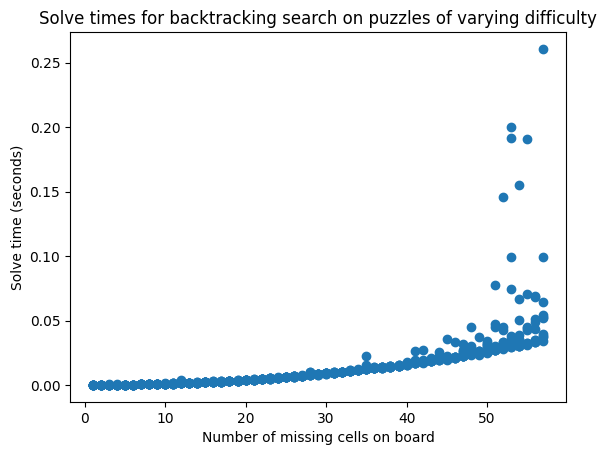

In [999]:
plt.scatter(constraintPropRuns.boardSize, constraintPropRuns.solveTime)
plt.title('Solve times for backtracking search on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Solve time (seconds)')

Text(0, 0.5, 'Solve time (seconds)')

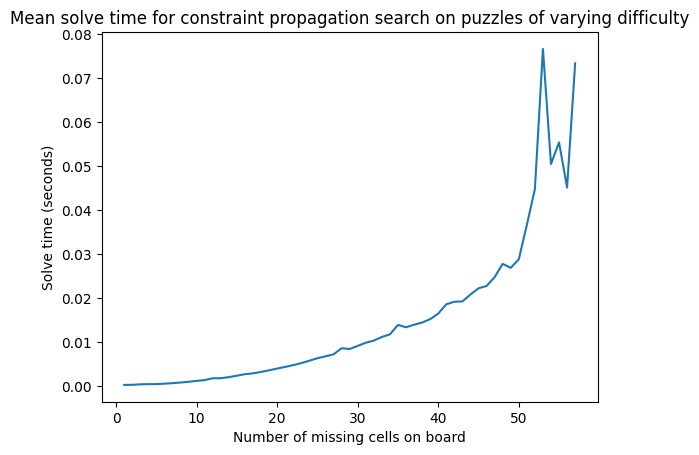

In [992]:
plt.plot(constraintPropRuns.groupby('boardSize')['solveTime'].mean())
plt.title('Mean solve time for constraint propagation search on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Solve time (seconds)')

In [15]:
board1 = np.array([[5, '_', 4, '_', 7, 8, '_', '_', 2],
       ['_', '_', 2, '_', 9, '_', 3, 4, 8],
       [1, 9, 8, '_', 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, '_', '_', 2, 3],
       [4, 2, 6, '_', 5, '_', 7, '_', 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, '_', 7, 2, '_', 4],
       ['_', 8, 7, 4, 1, 9, 6, 3, 5],
       [3, '_', '_', '_', 8, 6, 1, 7, 9]])

game = SudokuGame(boards[20][1].copy())
backtrackingSearch(game)

Solution found in 20 steps!


(array([[5, 3, 4, 6, 7, 8, 9, 1, 2],
        [6, 7, 2, 1, 9, 5, 3, 4, 8],
        [1, 9, 8, 3, 4, 2, 5, 6, 7],
        [8, 5, 9, 7, 6, 1, 4, 2, 3],
        [4, 2, 6, 8, 5, 3, 7, 9, 1],
        [7, 1, 3, 9, 2, 4, 8, 5, 6],
        [9, 6, 1, 5, 3, 7, 2, 8, 4],
        [2, 8, 7, 4, 1, 9, 6, 3, 5],
        [3, 4, 5, 2, 8, 6, 1, 7, 9]], dtype=object),
 0.010713815689086914)